In [8]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
import sys  
sys.path.append('../')
from util.util import *
from util.dataPreproc import *
from util import importNotebook
from util.dataProcess import *
from data_augmentation import augment

import os
from time import time
os.environ["CUDA_VISIBLE_DEVICES"] = '0' 
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Reshape, UpSampling3D 
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv3D, MaxPooling3D, ZeroPadding3D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD
import cv2

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


importing Jupyter notebook from ../util/dataProcess.ipynb
importing Jupyter notebook from data_augmentation.ipynb


# Load and preprocess the videos (1 frames)

In [9]:
name_file = "../data/Img_list_180x135.pkl"
with open(name_file, "rb") as file:
    img_list_all = pickle.load(file)

for v in range(len(img_list_all)):
    # Each list has many images and only reserve the last 80 images (frames)
    img_list_all[v] = img_list_all[v][-1:] 

for i in range(len(img_list_all)):
    print("Video", i, ",", "Filename:", img_list_all[i][0][2], \
          ",", "Frames:", len(img_list_all[i]), "," \
          , "Label:", img_list_all[i][0][4], ",", "Pads:", img_list_all[i][0][3])

Video 0 , Filename: 0009_162554-0000_NGH , Frames: 1 , Label: Good , Pads: C
Video 1 , Filename: 0012_163301-0000 , Frames: 1 , Label: Good , Pads: C
Video 2 , Filename: 0005_150213-0000 , Frames: 1 , Label: Good , Pads: R
Video 3 , Filename: 0006_162043-0000 , Frames: 1 , Label: Good , Pads: R
Video 4 , Filename: 0008_162545-0000 , Frames: 1 , Label: Good , Pads: R
Video 5 , Filename: 0011_163251-0000 , Frames: 1 , Label: Good , Pads: R
Video 6 , Filename: 0014_163903-0000 , Frames: 1 , Label: Good , Pads: R
Video 7 , Filename: 0002_120239-0000 , Frames: 1 , Label: Good , Pads: S
Video 8 , Filename: 0013_163311-0000 , Frames: 1 , Label: Good , Pads: S
Video 9 , Filename: 0007_162053-0000 , Frames: 1 , Label: Not_Full , Pads: S
Video 10 , Filename: 0010_162604-0000 , Frames: 1 , Label: Not_Full , Pads: S
Video 11 , Filename: 0003_140341-0000 , Frames: 1 , Label: Not_Melt , Pads: C
Video 12 , Filename: 0015_163912-0000 , Frames: 1 , Label: Not_Melt , Pads: C
Video 13 , Filename: 0001_11

# Pick the testing videos

In [10]:
ind_test = [81, 82, 30, 31, 6, 20, 28, 47, 57, 69]
img_list_train = []
img_list_test = []
img_list_other = []
for i in range(len(img_list_all)):
    if img_list_all[i][0][4] == "Other":
        img_list_other.append(img_list_all[i])
    else:
        if i in ind_test:
            img_list_test.append(img_list_all[i])
        else:
            img_list_train.append(img_list_all[i])

# Augmentor_Keras_Array_Data (CNN Approach)

In [11]:
import Augmentor
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

#### Data Preparation

In [12]:
# Original data are only deemed as testing data
label_dict = {'Good': 0, 'Not_Melt': 1, 'Not_Full': 2, 'Other': 3, 'BurnGreen': 4, 'Sn_Link': 5}

X_test = np.empty(shape=(len(img_list_all), 135, 180))
y_test = np.zeros(shape=(len(img_list_all), ))
for i in range(len(img_list_all)):
    X_test[i] = img_list_all[i][0][0]
    y_test[i] = label_dict[img_list_all[i][0][4]]

# Crop images
X_test_crop = np.empty(shape=(len(img_list_all), 135, 135))
for i in range(len(img_list_all)):
    X_test_crop[i] = X_test[i][:, 25:160] # 135 x 135

#### Split testing and training dataset

In [13]:
# read the benchmark cases
cases = np.array(pd.read_excel("benchmark_cases.xlsx", header=None))
BGSN_list = []
cases_nBGSN = [] # cases without BurnGreen and SN_Link
for i, case in enumerate(cases):
    if (sum(y_test[case] == 4) > 0) or (sum(y_test[case] == 5) > 0):
        BGSN_list.append(i)
    else:
        cases_nBGSN.append(case)
cases_nBGSN = np.array(cases_nBGSN)
BGSN_list = np.array(BGSN_list)
BGSN_list

array([ 0,  2,  3,  4,  5, 10, 12, 14, 15, 17, 18, 21, 22, 24, 26, 28, 33,
       34, 35, 36, 37, 39])

#### Augmentor

In [6]:
def construct_augmentor():
    p = Augmentor.Pipeline()
    p.rotate90(probability=0.5)
    p.rotate180(probability=0.5)
    p.rotate270(probability=0.5)
    p.rotate(probability=0.5, max_left_rotation=5, max_right_rotation=5) # probability=1為必轉
    p.flip_left_right(probability=0.5)
    p.flip_random(probability=0.5)
    p.flip_top_bottom(probability=0.5)
    p.random_distortion(probability=0.5, grid_width=2, grid_height=2, magnitude=4) # probability=1為必扭
    # p.status()
    return p

In [1]:
def generate_rotated_image():
    r = Augmentor.Pipeline()
    r.rotate90(probability=0.5)
    r.rotate180(probability=0.5)
    r.rotate270(probability=0.5)
    r.flip_left_right(probability=0.5)
    r.flip_random(probability=0.5)
    r.flip_top_bottom(probability=0.5)
    return r

#### Compiled Model

In [14]:
def construct_model():
    num_classes = 3
    input_shape = (135, 135, 1)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))

    # model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    # model.add(Dropout(0.25))
    # model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

## 將全部的流程寫成Function以便testing

In [19]:
def testing_pipeline(X_data=None,  # preprocessed total data
                     y_data=None, 
                     test_case=[81, 82, 30, 31, 6, 20, 28, 47, 57, 69],
                     compiled_cnn_model=None,
                     augmentor=None,
                     rotator=None,
                     case_name=None):
    
    # Data Preparation --------------
    # generate training data from all data
    X_train = np.delete(X_data, obj=test_case, axis=0)
    y_train = np.delete(y_data, obj=test_case, axis=0)
    
    
    # Data Augmentation --------------
    Good = X_train[y_train == 0]
    Not_Melt = X_train[y_train == 1]
    Not_Full = X_train[y_train == 2]
    # Other = X_test_crop[y_train == 3]
    
    augment_numbers = 3000
    # 0
    class_Good = augmentor.keras_generator_from_array(images=Good, 
                                              labels=[0] * Good.shape[0], 
                                              batch_size=augment_numbers)
    # 1
    class_Not_Melt = augmentor.keras_generator_from_array(images=Not_Melt, 
                                                  labels=[1] * Not_Melt.shape[0], 
                                                  batch_size=augment_numbers)
    # 2
    class_Not_Full = augmentor.keras_generator_from_array(images=Not_Full, 
                                                  labels=[2] * Not_Full.shape[0], 
                                                  batch_size=augment_numbers)
    # 3
    # class_Other = augmentor.keras_generator_from_array(images=Other, 
    #                                            labels=[3] * Other.shape[0], 
    #                                            batch_size=batch_size)
    
    
    # 原本Data也各抽個幾張放進去
    
    rotate_numbers = 1000
    # 0
    Origin_Good = rotator.keras_generator_from_array(images=Good, 
                                                     labels=[0] * Good.shape[0], 
                                                     batch_size=rotate_numbers)
    # 1
    Origin_Not_Melt = rotator.keras_generator_from_array(images=Not_Melt, 
                                                         labels=[1] * Not_Melt.shape[0], 
                                                         batch_size=rotate_numbers)
    # 2
    Origin_Not_Full = rotator.keras_generator_from_array(images=Not_Full, 
                                                         labels=[2] * Not_Full.shape[0], 
                                                         batch_size=rotate_numbers)
    
    # Training data preprocessing --------------
    # stack the numpy array from each class generator
    
    X, _ = next(class_Good)
    for image_generator in [Origin_Good, class_Not_Melt, Origin_Not_Melt, class_Not_Full, Origin_Not_Full]: # the order matters
        tmp_X, _ = next(image_generator)
        X = np.vstack([X, tmp_X])
    
    classes_numbers = 3
    y = np.repeat(range(classes_numbers), (augment_numbers + rotate_numbers))
    
    shuffle_idxs = np.random.permutation(X.shape[0])
    X_shuffled = X[shuffle_idxs].copy()
    y_shuffled = y[shuffle_idxs].copy()
    # Label Transformation
    y_shuffled = Augmentor.Pipeline.categorical_labels(y_shuffled)
    
    
    # Fit and save the model --------------
    compiled_cnn_model.fit(X_shuffled, y_shuffled, validation_split=0.4, epochs=20, batch_size=256)
    compiled_cnn_model.save(f"./models_of_test_cases/{case_name}.h5")
    
    # Testing --------------
    
    # test data preprocess
    test_imgs = X_data[test_case]
    
    if test_imgs.ndim < 4:
        test_imgs = np.expand_dims(test_imgs, axis=3)
    
    preds = compiled_cnn_model.predict_classes(test_imgs)
    grounds = y_data[test_case]
    
    only_GB_accuracy = sum((grounds == 0) == (preds == 0)) / grounds.shape[0]
    multiple_class_accuracy = sum(grounds == preds) / grounds.shape[0]
    
    # Good(0): negative; Bad(1, 2, 3): positive
    neg_grounds = np.where((grounds == 0))[0]
    FP_rate = sum(preds[neg_grounds] != 0) / neg_grounds.shape[0]
    
    pos_grounds = np.where((grounds != 0))[0]
    FN_rate = sum(preds[pos_grounds] == 0) / pos_grounds.shape[0]
    
    return np.array([only_GB_accuracy, multiple_class_accuracy, FP_rate, FN_rate])

In [241]:
X[0].shape

(135, 135, 1)

## For demostration the augmentation effect

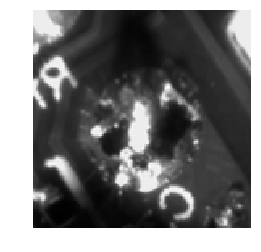

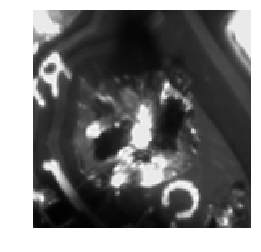

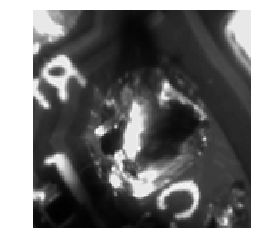

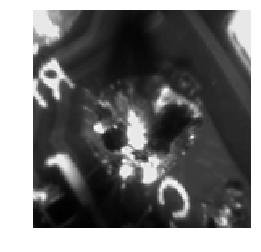

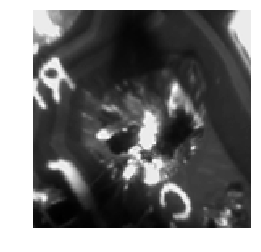

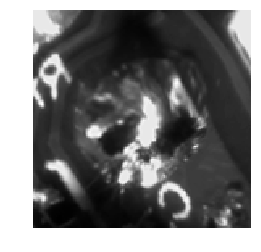

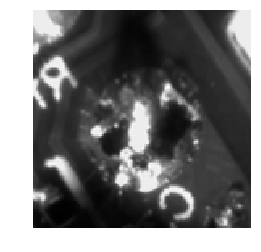

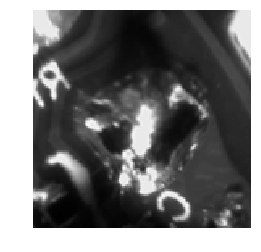

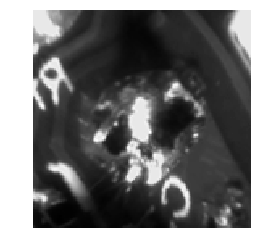

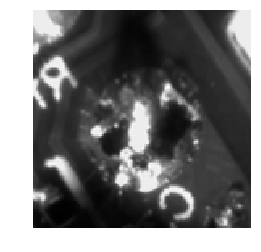

In [258]:
a = Augmentor.Pipeline()
# a.rotate90(probability=0.2)
# a.rotate180(probability=0.8)
# a.rotate270(probability=0.8)
# a.rotate(probability=1, max_left_rotation=10, max_right_rotation=10) # probability=1為必轉
# a.flip_left_right(probability=1)
# a.flip_random(probability=0.8)
# a.flip_top_bottom(probability=0.8)
a.random_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=8) # probability=1為必扭
demo = a.keras_generator_from_array(images=X[0].reshape((1, 135, 135, 1)), 
                              labels=[0], 
                              batch_size=10)

X_demo, _ = next(demo)

for i in range(10):
    plt.imshow(X_demo[i].reshape(135, 135), cmap='gray')
    plt.axis('off')
    plt.show()

In [259]:
m = load_model("./models_of_test_cases/with_other/0.h5")
m.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 133, 133, 32)      320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 66, 66, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2097184   
_________________________________________________________________
dense_17 (Dense)             (None, 16)                528       
__________

In [20]:
result = {}
for i, case in enumerate(cases):
    augmentor = construct_augmentor()
    model = construct_model()
    model.compile(loss=categorical_crossentropy,
                      optimizer=Adam(beta_1 = 0.5),
                      metrics=['accuracy'])

    output = testing_pipeline(X_data=X_test_crop,  # preprocessed total data
                              y_data=y_test, 
                              test_case=case,
                              compiled_cnn_model=model,
                              augmentor=augmentor,
                              classes_numbers=3,
                              case_name=i)
    
    print(f"The case index is:{i}, result:{output}")
    result[i] = output

AttributeError: 'NoneType' object has no attribute 'keras_generator_from_array'

### 單跑某個case

In [23]:
augmentor = construct_augmentor()
rotator = generate_rotated_image()
model = construct_model()
model.compile(loss=categorical_crossentropy,
                  optimizer=Adam(beta_1 = 0.5),
                  metrics=['accuracy'])

output = testing_pipeline(X_data=X_test_crop,  # preprocessed total data
                          y_data=y_test, 
                          test_case=[35, 83, 29, 84, 79, 71, 36, 15,  4,  8],
                          compiled_cnn_model=model,
                          augmentor=augmentor,
                          rotator=rotator,
                          classes_numbers=3,
                          case_name="Add_origin_trial") # case number

Train on 7200 samples, validate on 4800 samples
Epoch 1/20
7200/7200 [==============================] - 4s 593us/step - loss: 1.0055 - acc: 0.4946 - val_loss: 0.8329 - val_acc: 0.6479
Epoch 2/20
7200/7200 [==============================] - 4s 512us/step - loss: 0.6533 - acc: 0.7150 - val_loss: 0.4820 - val_acc: 0.7879
Epoch 3/20
7200/7200 [==============================] - 4s 510us/step - loss: 0.3750 - acc: 0.8592 - val_loss: 0.2423 - val_acc: 0.9294
Epoch 4/20
7200/7200 [==============================] - 4s 506us/step - loss: 0.1203 - acc: 0.9685 - val_loss: 0.1059 - val_acc: 0.9694
Epoch 5/20
7200/7200 [==============================] - 4s 520us/step - loss: 0.0486 - acc: 0.9889 - val_loss: 0.0535 - val_acc: 0.9873
Epoch 6/20
7200/7200 [==============================] - 4s 509us/step - loss: 0.0223 - acc: 0.9961 - val_loss: 0.0202 - val_acc: 0.9958
Epoch 7/20
7200/7200 [==============================] - 3s 483us/step - loss: 0.0113 - acc: 0.9993 - val_loss: 0.0142 - val_acc: 0.9965


In [24]:
print(case)
print(output)

[87 95 11 83  0 55  4 21  2 19]
[0.5        0.5        0.33333333 0.75      ]


In [18]:
cases

array([[87, 95, 11, 83,  0, 55,  4, 21,  2, 19],
       [84,  9, 32, 86, 24, 37, 74, 75, 51, 43],
       [10, 95, 82, 88, 42, 20, 25, 60, 66,  2],
       [95, 32, 31, 88, 50, 47, 68, 27, 71, 19],
       [35, 11,  9, 32, 48, 70, 47,  8, 15, 50],
       [11, 29, 86, 95, 50, 69,  3, 52, 22, 75],
       [85,  9, 84, 88, 65, 24, 46, 40, 62, 64],
       [82, 85, 81, 88, 23, 74, 15, 51, 40, 68],
       [84, 11, 88, 31, 19, 59, 67, 24, 61,  8],
       [32, 88, 31, 11, 74, 65, 38, 55, 78, 39],
       [29, 10, 87, 35, 20, 59, 68, 61, 28, 27],
       [11, 29, 32, 84, 63,  1, 69, 68, 59, 75],
       [35, 83, 29, 84, 79, 71, 36, 15,  4,  8],
       [11, 10, 30, 82, 15,  4, 66,  7, 54, 22],
       [29, 95, 83, 87, 50, 76,  1, 73, 55, 21],
       [31, 86, 11, 35, 75, 26, 24, 80,  2, 60],
       [30, 88, 31, 11, 80, 22, 73, 45, 41, 44],
       [95, 84, 82, 11, 37, 72, 36, 58, 49, 43],
       [11,  9, 35, 32, 38, 64, 19, 55, 68,  0],
       [31, 83, 85, 11, 55, 59, 36, 41, 52, 26],
       [81, 87, 88, 

### Show the result: [GB_Accuracy, Multiple_Class_Accuracy, FP_rate, FN_rate]

In [7]:
result_array = np.array(list(result.values()))

All = np.mean(result_array, axis=0)
nBGSN = np.mean(result_array[BGSN_list], axis=0)
print(f"連BurnGreen和SN_Link一起分:\n\tAcc(GB):{All[0]}\n\tAcc(M):{All[1]}\n\tFP_rate:{All[2]}\n\tFN_rate:{All[3]}")
print(f"不看BurnGreen和SN_Link:\n\tAcc(GB):{nBGSN[0]}\n\tAcc(M):{nBGSN[1]}\n\tFP_rate:{nBGSN[2]}\n\tFN_rate:{nBGSN[3]}")

NameError: name 'result' is not defined

## Save the result

In [178]:
without_other = pd.DataFrame(result_array)
without_other.to_csv("20181220_wo_other_result_v1.csv")

## Analyze the wrongly classified sample

In [183]:
label_dict = {0: 'Good', 1: 'Not_Melt', 2: 'Not_Full', 3: 'Other', 4: 'BurnGreen', 5: 'Sn_Link'}

def find_error_pred(model=None, 
                    X_data=X_test_crop,
                    y_data=y_test, 
                    test_case=None):
    
    test_imgs = X_data[test_case]
    
    if test_imgs.ndim < 4:
        test_imgs = np.expand_dims(test_imgs, axis=3)
    
    preds = model.predict_classes(test_imgs)
    grounds = y_data[test_case]
    
    # extract strings from dictionary
    label_preds = np.array([label_dict[p] for p in preds])
    label_grounds = np.array([label_dict[r] for r in grounds])
    
    comparison = []
    i = 0
    for g, p in zip(label_grounds, label_preds):
        if g == p:
            i += 1
        else:
            index = test_case[i]
            comparison.append((("ground:" + g), ("pred:" + p), index))
            i += 1
    return comparison

In [209]:
model_idx = 37
model = load_model(f"./models_of_test_cases/without_other/{model_idx}.h5")

find_error_pred(model=model,
               X_data=X_test_crop,
               y_data=y_test,
               test_case=cases[model_idx])

[('ground:Not_Full', 'pred:Good', 81),
 ('ground:BurnGreen', 'pred:Good', 35),
 ('ground:Not_Melt', 'pred:Good', 88),
 ('ground:Not_Full', 'pred:Good', 84)]

## Highlight the worse ones
##### 2
`[('ground:Not_Full', 'pred:Good', 10),
 ('ground:Sn_Link', 'pred:Good', 95),
 ('ground:Not_Full', 'pred:Good', 82),
 ('ground:Not_Melt', 'pred:Good', 88)]`
 
##### 12
`[('ground:BurnGreen', 'pred:Good', 35),
 ('ground:Not_Full', 'pred:Good', 83),
 ('ground:Not_Full', 'pred:Good', 84),
 ('ground:Good', 'pred:Not_Full', 8)]`
 
##### 18
`[('ground:Not_Melt', 'pred:Good', 11),
 ('ground:Not_Full', 'pred:Good', 9),
 ('ground:BurnGreen', 'pred:Good', 35),
 ('ground:Not_Melt', 'pred:Good', 32)]`
 
##### 25
`[('ground:Not_Full', 'pred:Good', 84),
 ('ground:Not_Melt', 'pred:Good', 30),
 ('ground:Not_Full', 'pred:Good', 83),
 ('ground:Good', 'pred:Not_Full', 36)]`
 
##### 32
`[('ground:Not_Full', 'pred:Good', 84),
 ('ground:Not_Full', 'pred:Good', 85),
 ('ground:Not_Full', 'pred:Good', 81),
 ('ground:Not_Melt', 'pred:Good', 87)]`
 
##### 37
`[('ground:Not_Full', 'pred:Good', 81),
 ('ground:BurnGreen', 'pred:Good', 35),
 ('ground:Not_Melt', 'pred:Good', 88),
 ('ground:Not_Full', 'pred:Good', 84)]`

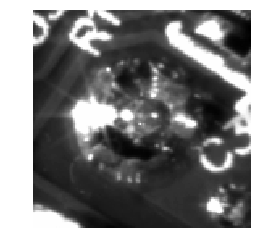

In [218]:
# 11 35 81 83 84  88 

# False Negative
# Not_Full -> Good (81, 83, 84, 85)
# Not_Melt -> Good (11, 30, 87, 88)
# BurnGreen -> Good (35)

# False Positive
# Good -> Not_Full (8, 36)

plt.imshow(X_test_crop[36], cmap='gray') # Label: Not_Full, Pred: Good
plt.axis('off')
plt.show()

## Grad Cam API
1. Official Web: https://raghakot.github.io/keras-vis/vis.visualization/#visualize_cam
2. Example (blog): http://marubon-ds.blogspot.com/2018/03/object-detection-by-cam-with-keras.html

In [220]:
from vis.visualization import visualize_cam

In [28]:
model_idx = 18
model = load_model(f"./models_of_test_cases/without_other/{model_idx}.h5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 133, 133, 32)      320       
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 66, 66, 32)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 65536)             0         
_________________________________________________________________
dense_88 (Dense)             (None, 32)                2097184   
_________________________________________________________________
dense_89 (Dense)             (None, 16)                528       
__________

In [29]:
# 11 35 81 83 84  88 

# False Negative
# Not_Full -> Good (81, 83, 84, 85)
# Not_Melt -> Good (11, 30, 87, 88)
# BurnGreen -> Good (35)

for i, idx in enumerate([11, 30, 35, 81, 83, 84, 85, 87, 88]):
    print(i, img_list_all[idx][0][3])

0 C
1 C
2 C
3 C
4 S
5 S
6 S
7 C
8 R


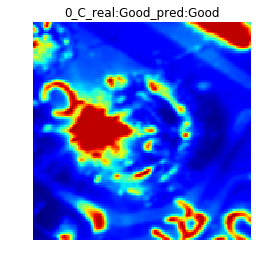

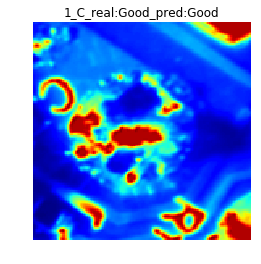

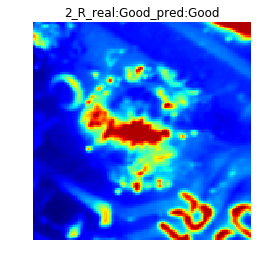

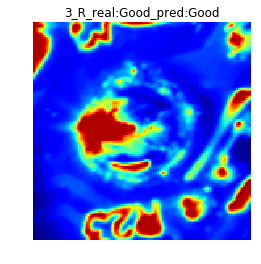

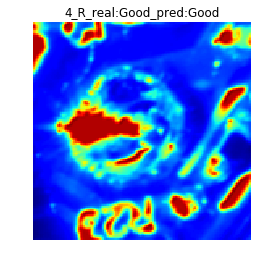

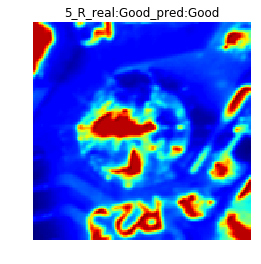

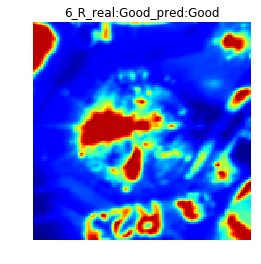

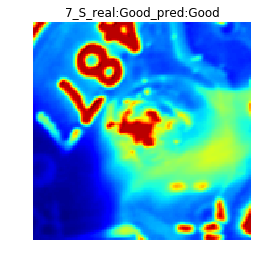

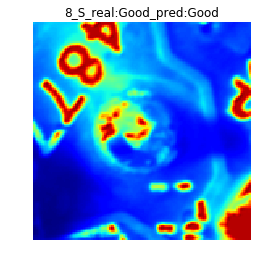

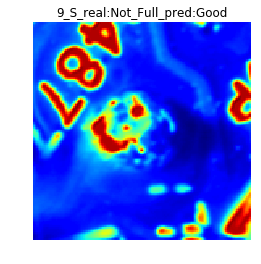

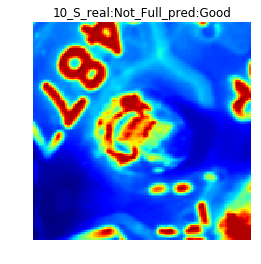

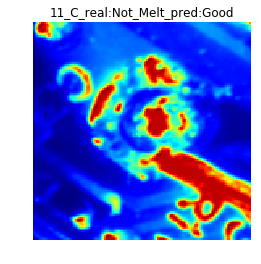

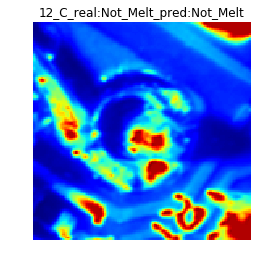

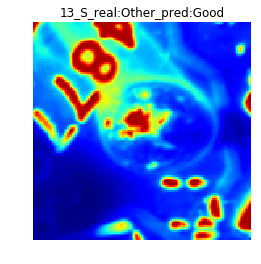

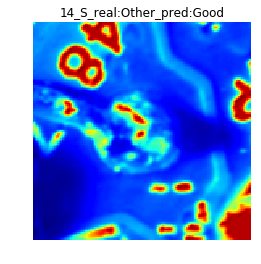

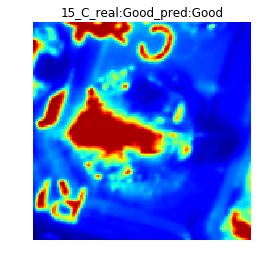

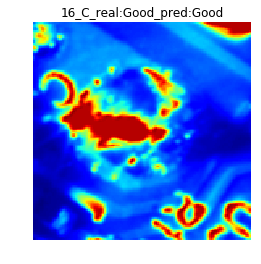

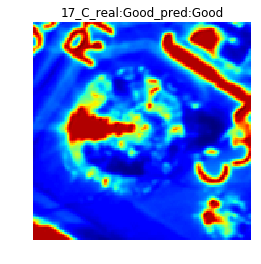

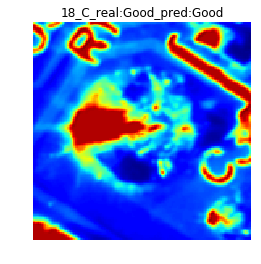

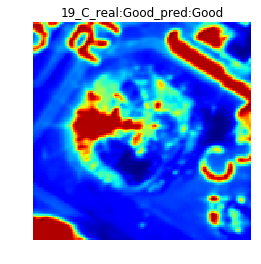

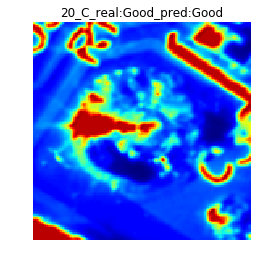

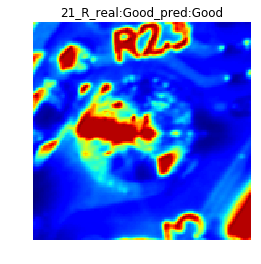

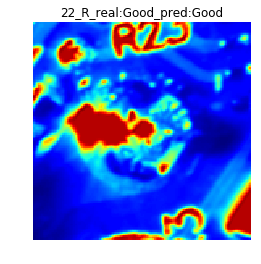

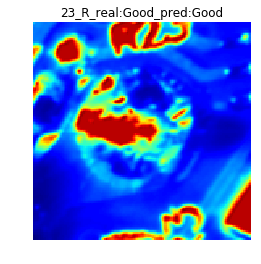

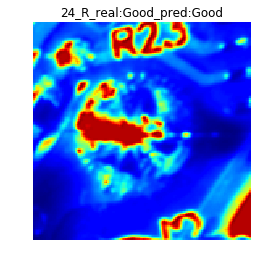

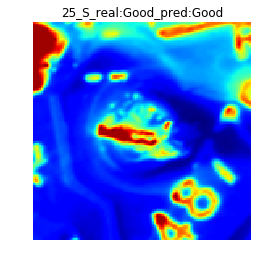

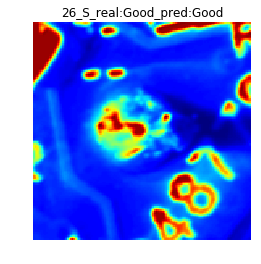

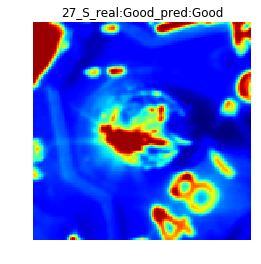

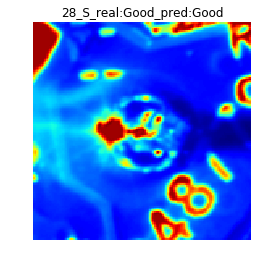

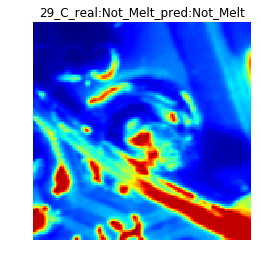

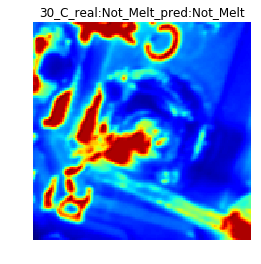

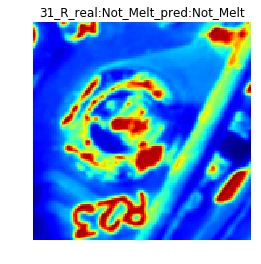

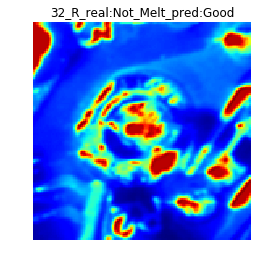

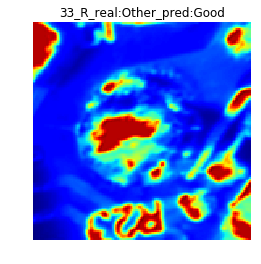

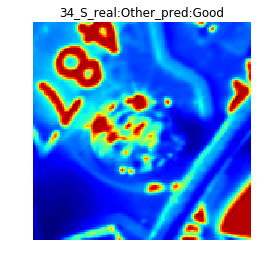

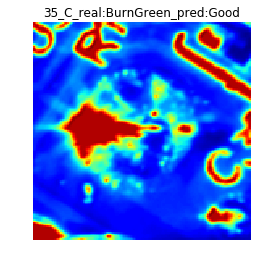

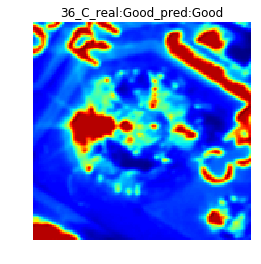

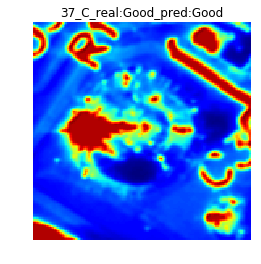

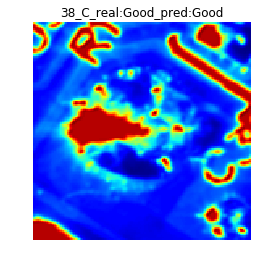

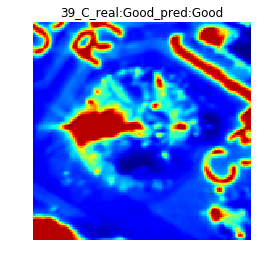

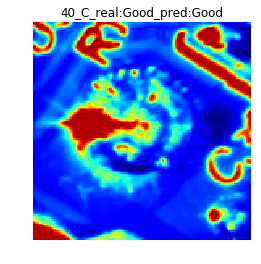

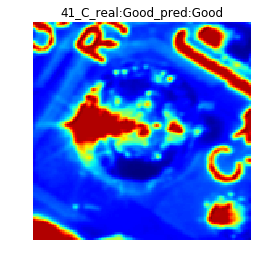

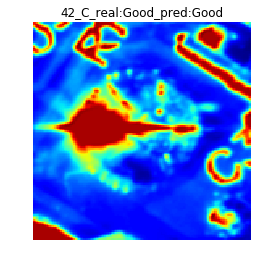

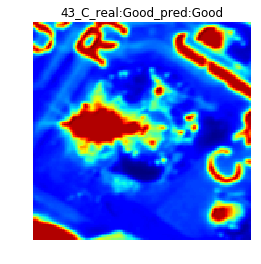

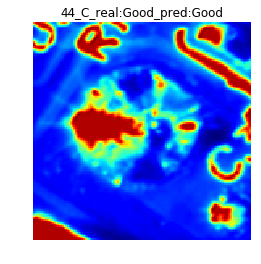

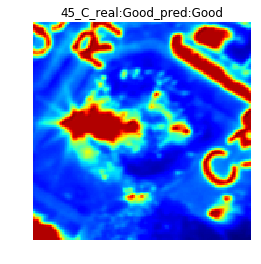

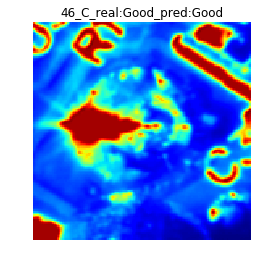

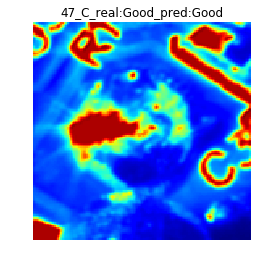

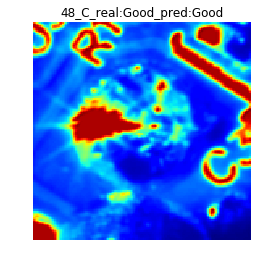

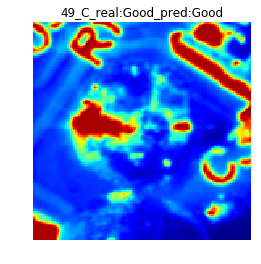

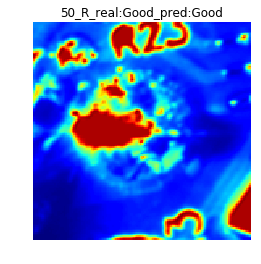

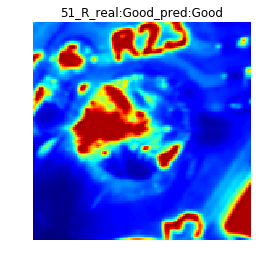

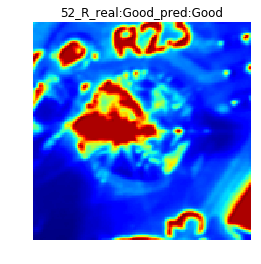

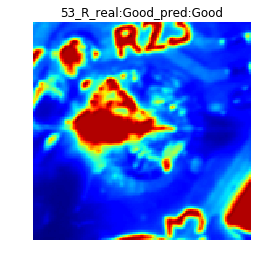

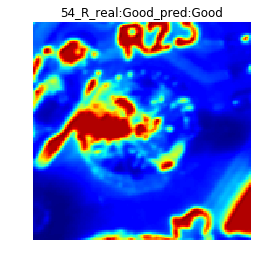

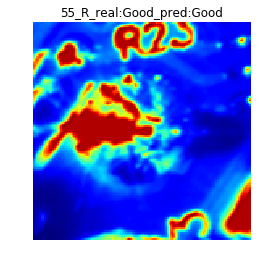

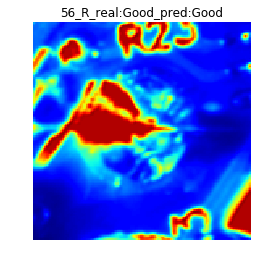

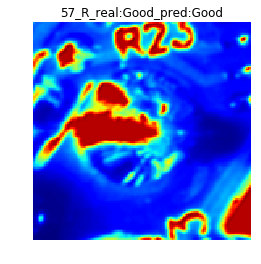

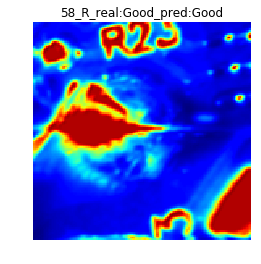

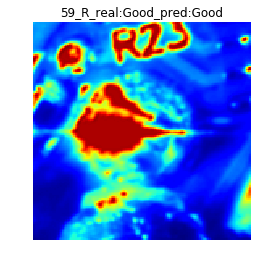

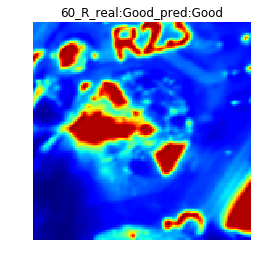

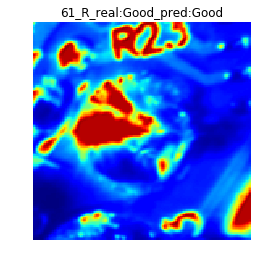

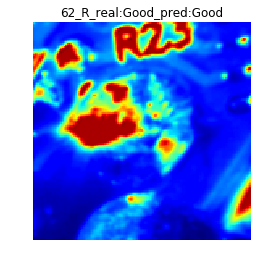

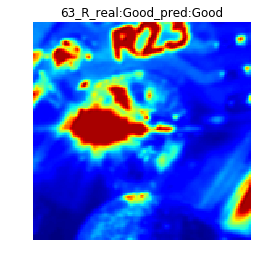

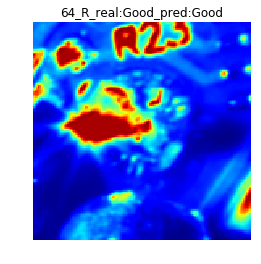

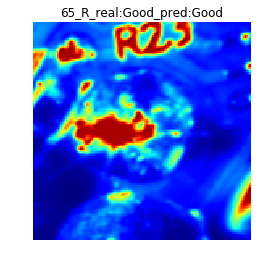

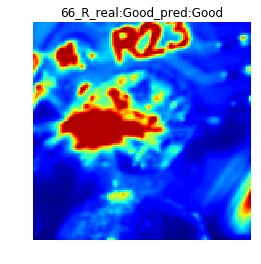

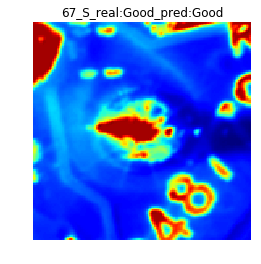

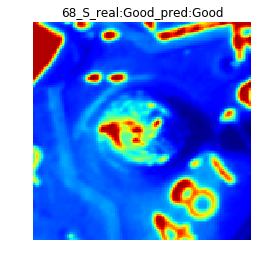

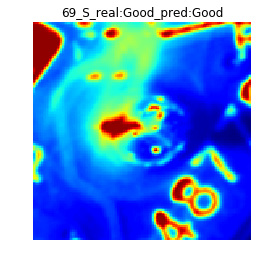

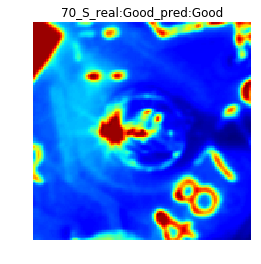

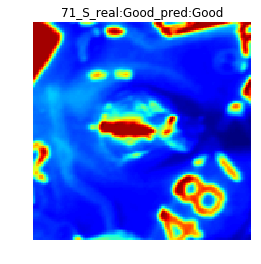

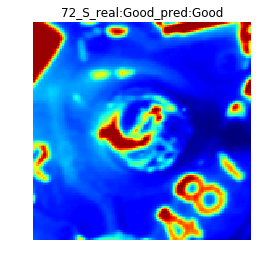

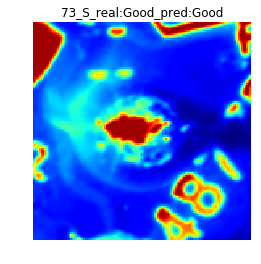

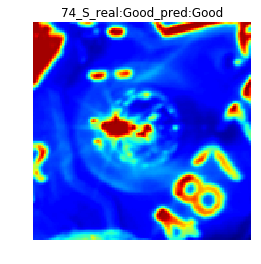

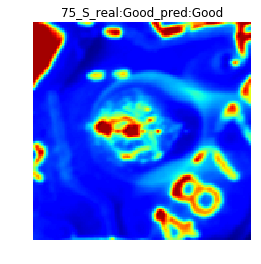

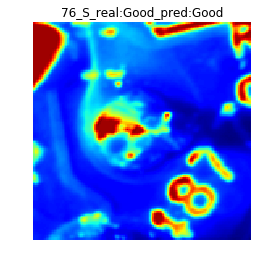

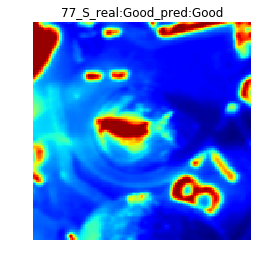

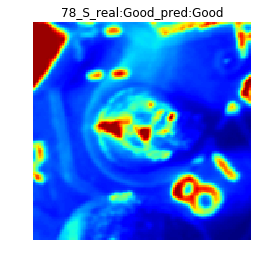

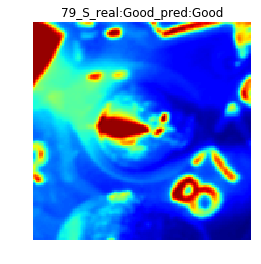

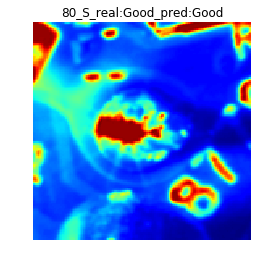

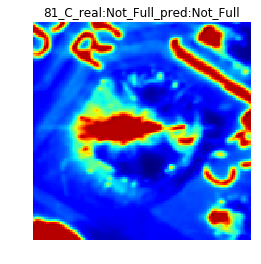

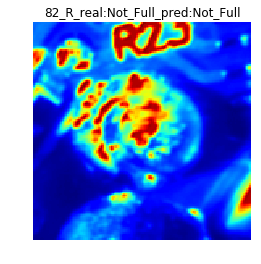

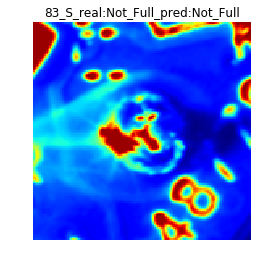

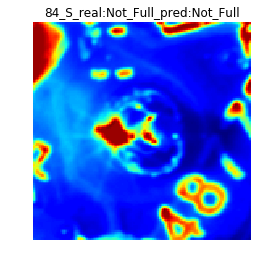

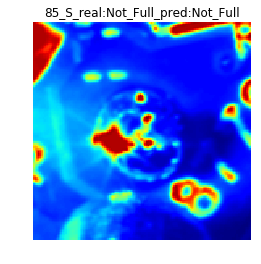

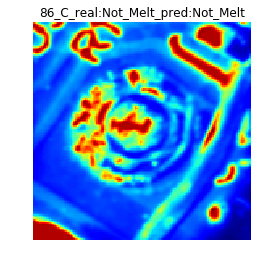

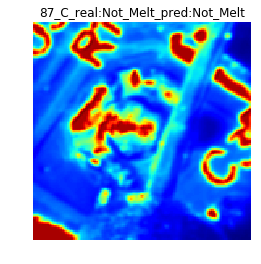

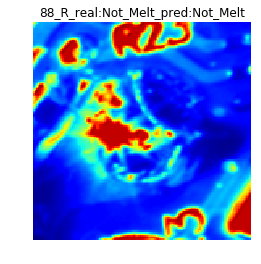

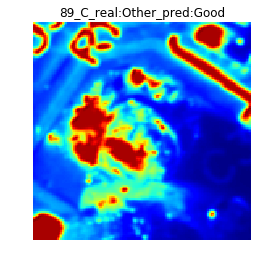

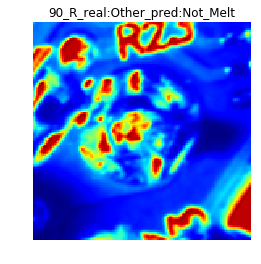

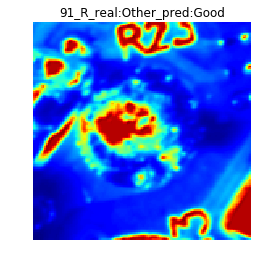

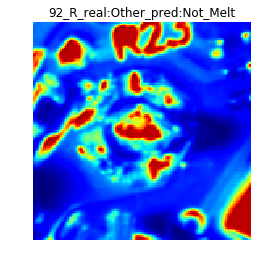

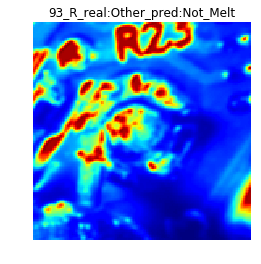

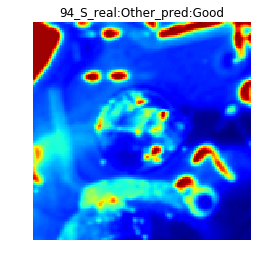

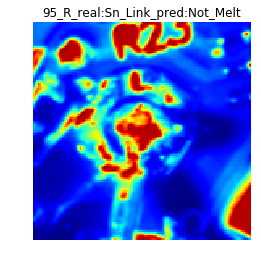

In [30]:
from vis.visualization import visualize_cam
reverse_label_dict = {0: 'Good', 1: 'Not_Melt', 2: 'Not_Full', 3: 'Other', 4: 'BurnGreen', 5: 'Sn_Link'}

idx = 83

for idx in range(96):
    img_4_cam = X_test_crop[idx].reshape((1, 135, 135, 1))
    y_pred = model.predict_classes(img_4_cam)[0]

    heat_map = visualize_cam(model=model, layer_idx=2, filter_indices=None, seed_input=img_4_cam)
    plt.imshow(heat_map)
    plt.axis('off')
    plt.title(f"{idx}_{img_list_all[idx][0][3]}_real:{reverse_label_dict[y_test[idx]]}_pred:{reverse_label_dict[y_pred]}")
    plt.show()

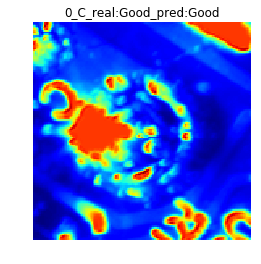

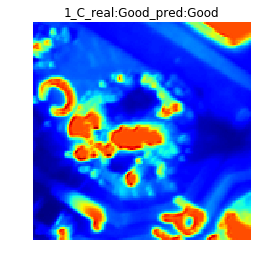

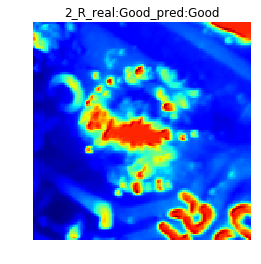

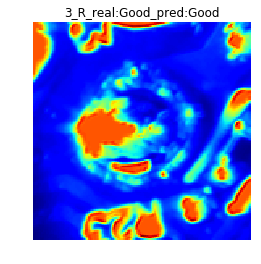

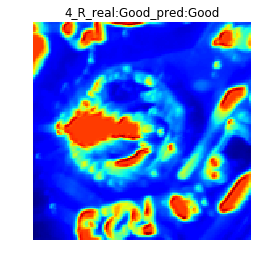

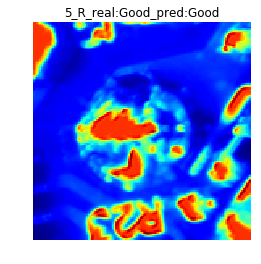

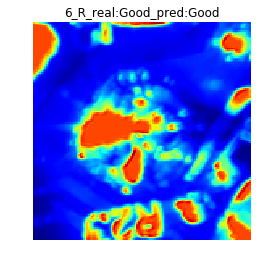

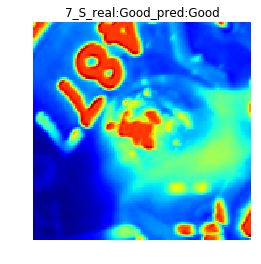

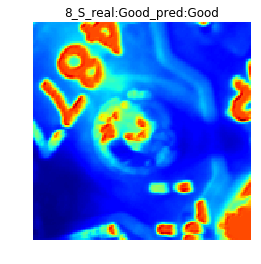

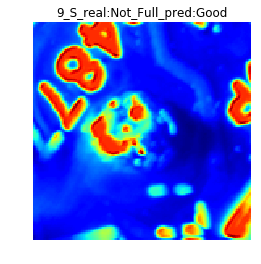

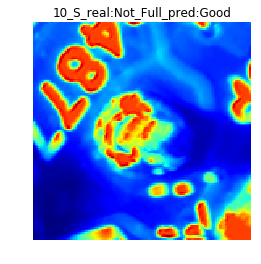

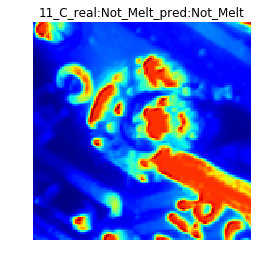

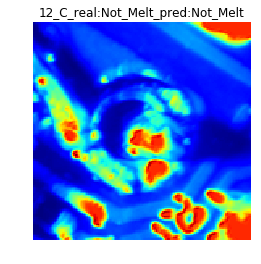

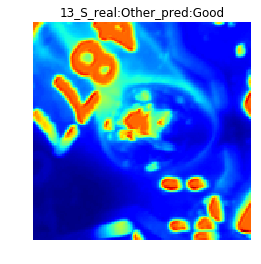

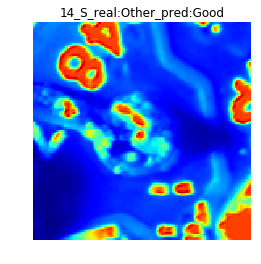

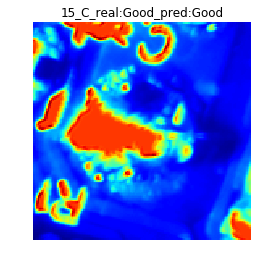

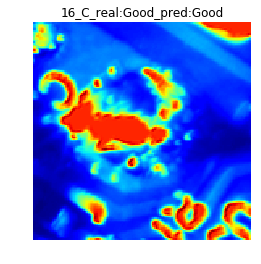

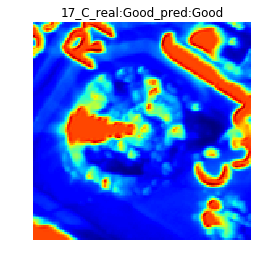

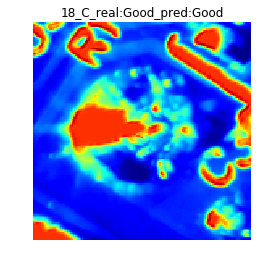

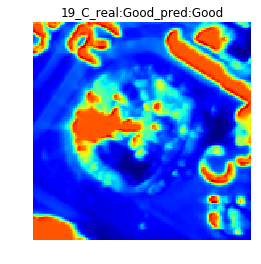

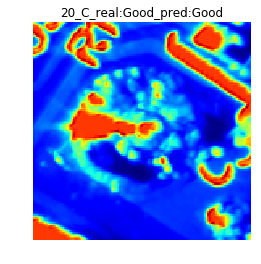

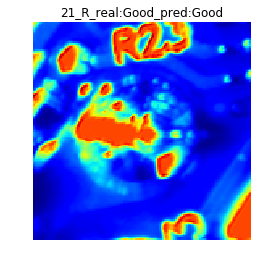

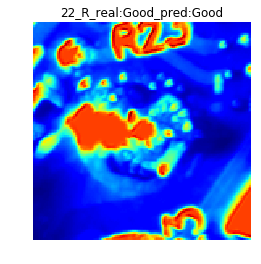

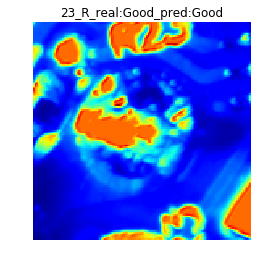

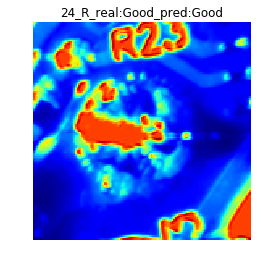

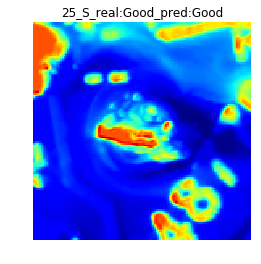

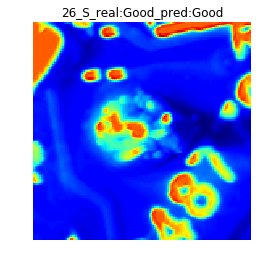

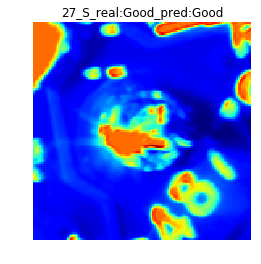

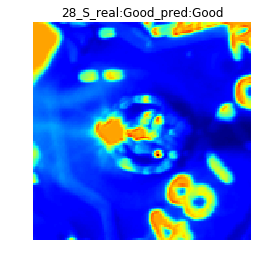

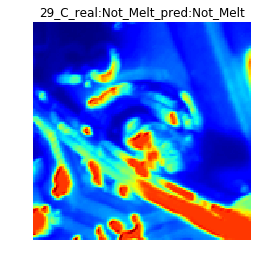

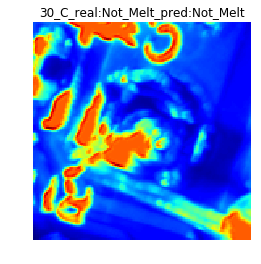

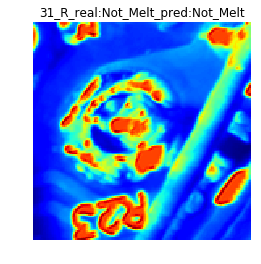

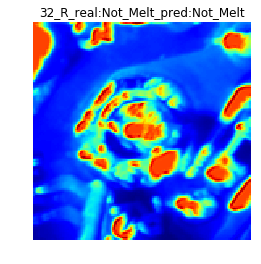

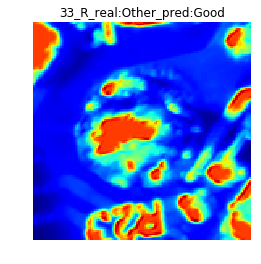

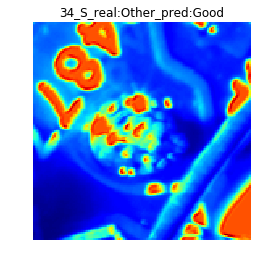

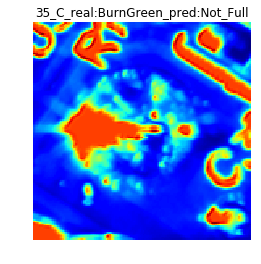

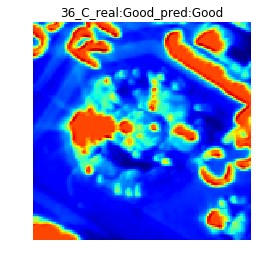

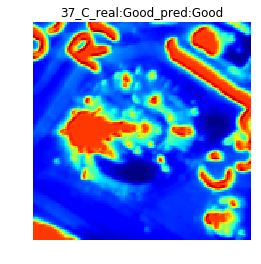

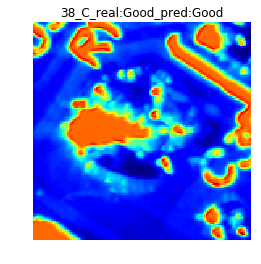

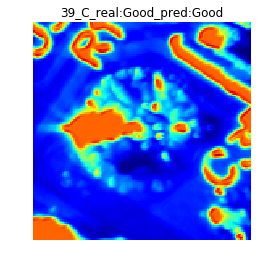

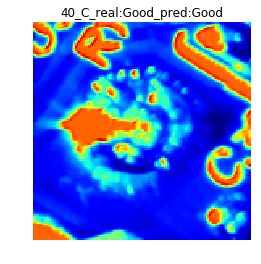

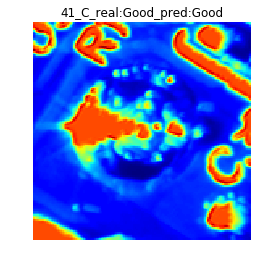

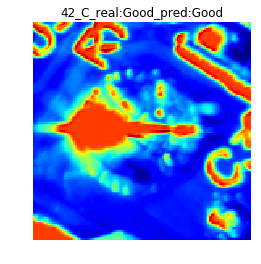

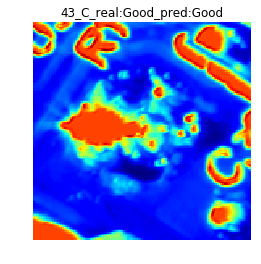

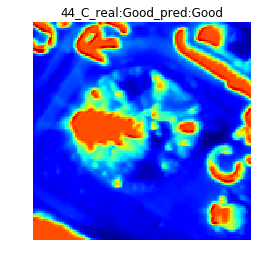

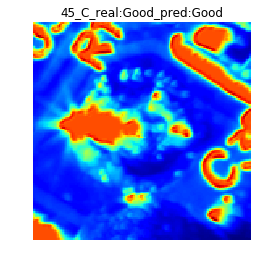

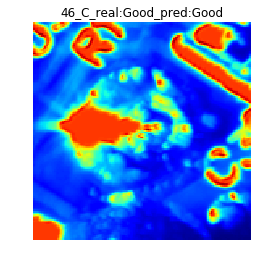

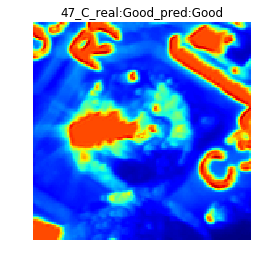

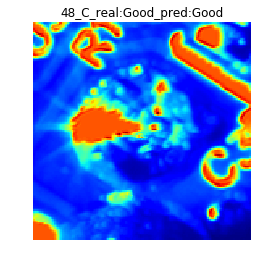

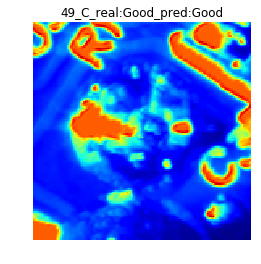

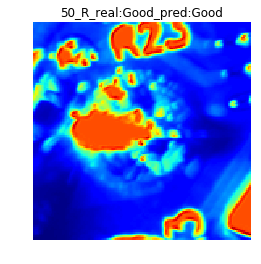

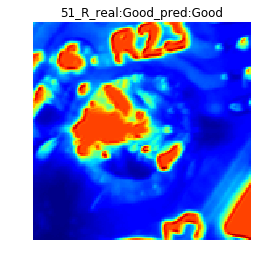

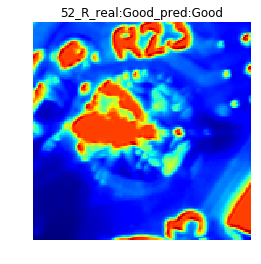

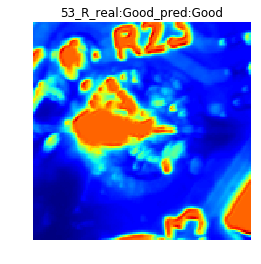

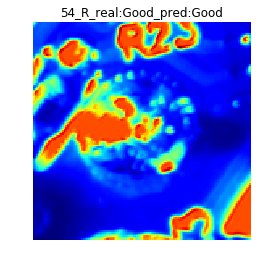

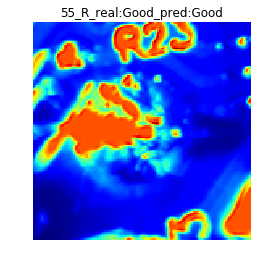

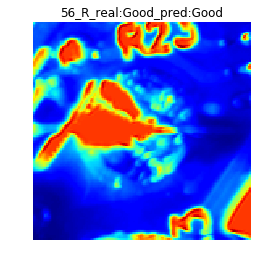

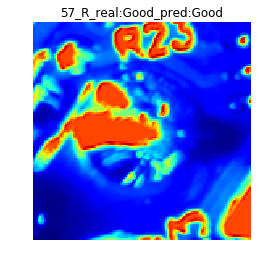

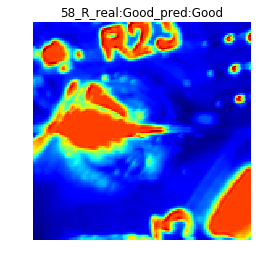

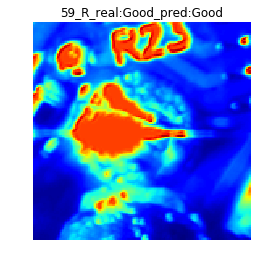

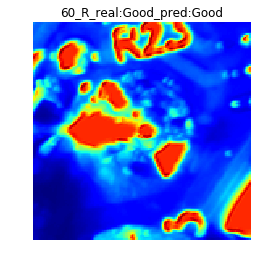

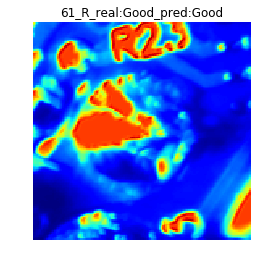

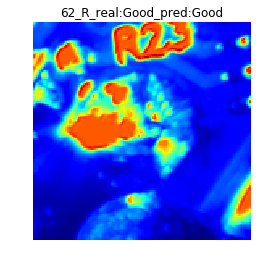

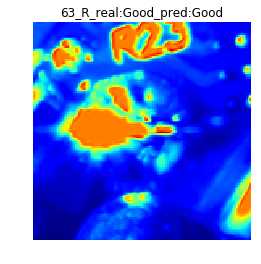

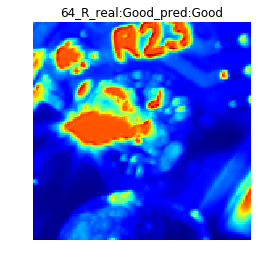

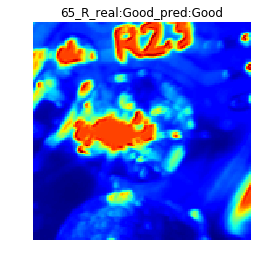

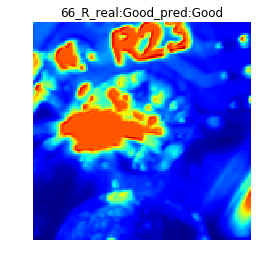

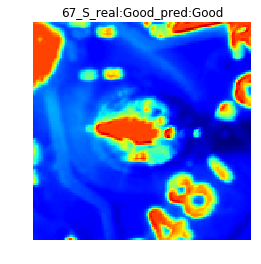

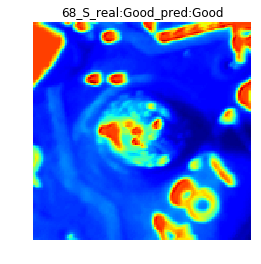

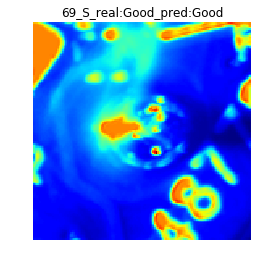

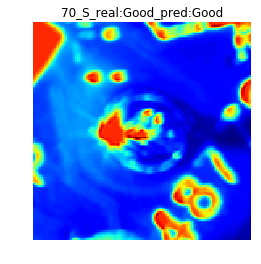

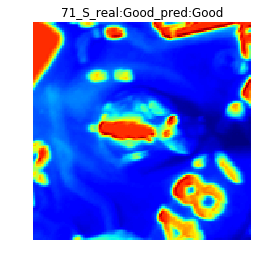

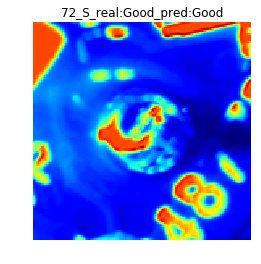

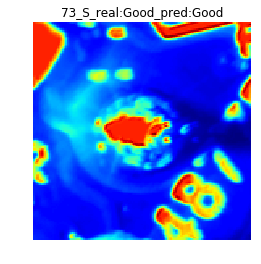

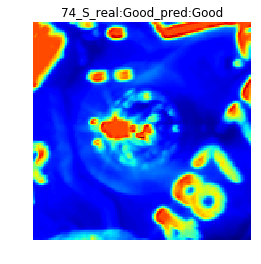

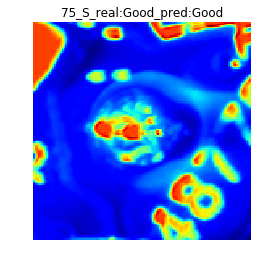

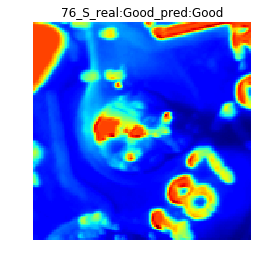

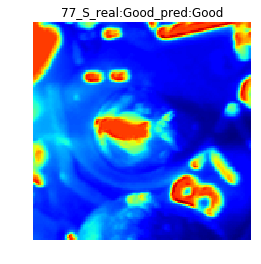

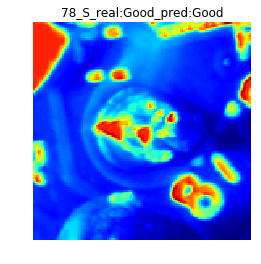

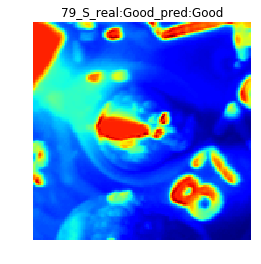

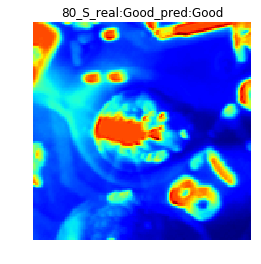

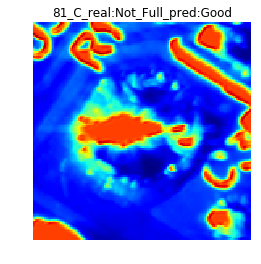

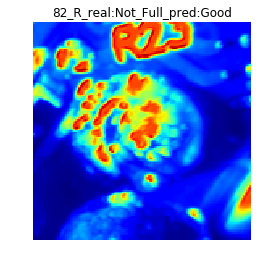

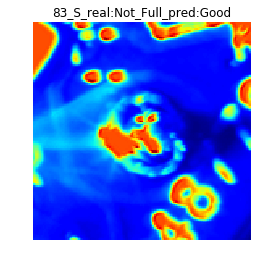

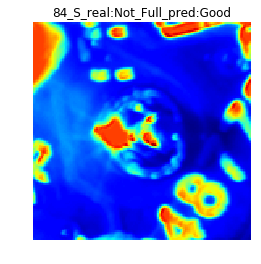

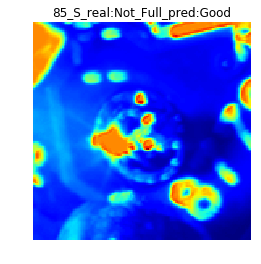

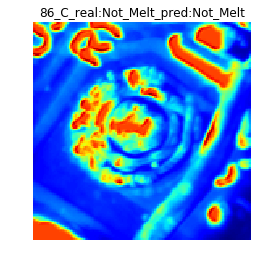

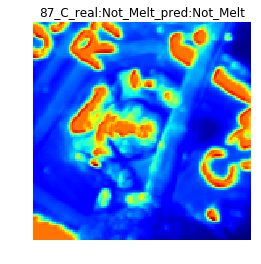

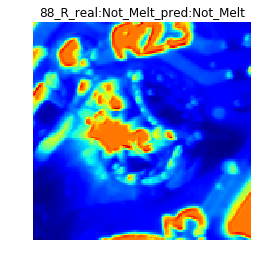

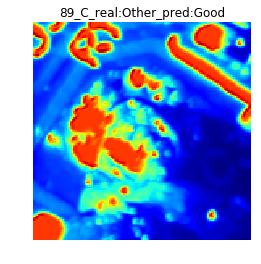

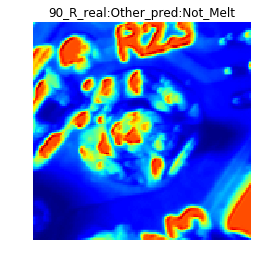

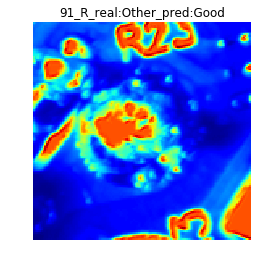

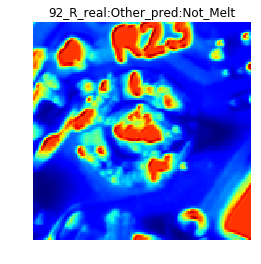

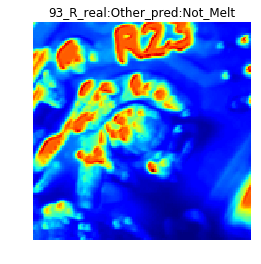

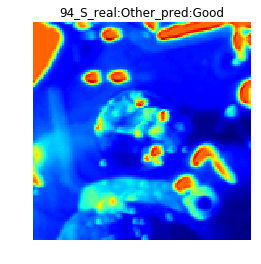

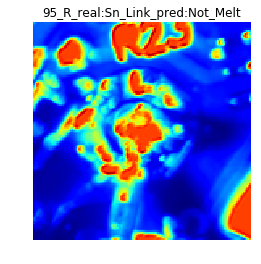

In [322]:
# idx = 6
# for idx in range(96):
#     img_x = preproc_n_extract(test_set=X_test_proc, indices=[idx])
#     y_pred = predict_decode(model=model, test_set=img_x)[0]

#     heat_map = visualize_cam(model=model, layer_idx=2, filter_indices=2, seed_input=img_x)
#     plt.imshow(heat_map)
#     plt.axis('off')
#     plt.title(f"{idx}_real:{y_origin_dict[y_test[idx]]}_pred:{y_pred_dict[y_pred]}")
#     plt.show()
#     print(y_origin_dict[y_test[idx]])
#     print(y_pred_dict[y_pred])

# for idx in range(96):
#     img_x = preproc_n_extract(test_set=X_test, indices=[idx])
#     y_pred = predict_decode(model=model, test_set=img_x)[0]
    
#     heat_map = visualize_cam(model=model, layer_idx=2, filter_indices=None, seed_input=img_x)
#     cv2.imwrite(f"wo_other_cnn_v1/{idx}_{img_list_all[idx][0][3]}_real:{y_origin_dict[y_test[idx]]}_pred:{y_pred_dict[y_pred]}.png", 
#                 cv2.cvtColor(heat_map, cv2.COLOR_BGR2RGB))
#     plt.imshow(heat_map)
#     plt.axis('off')
#     plt.title(f"{idx}_{img_list_all[idx][0][3]}_real:{y_origin_dict[y_test[idx]]}_pred:{y_pred_dict[y_pred]}")
#     plt.show()
    

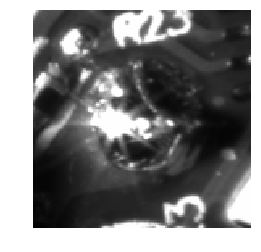

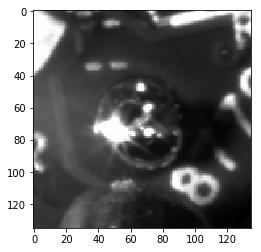

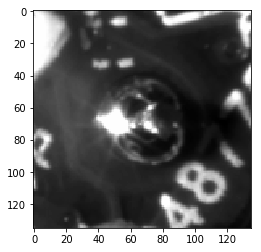

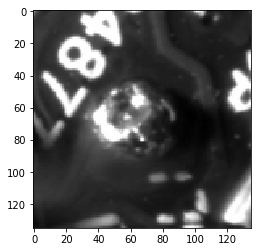

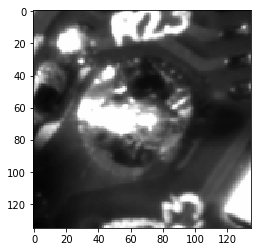

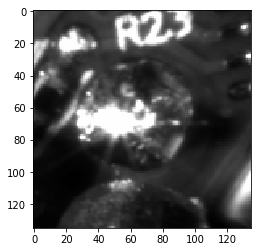

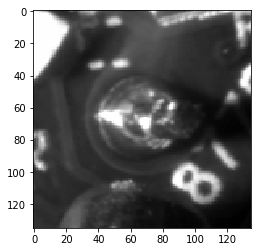

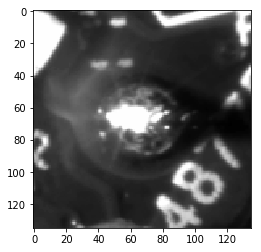

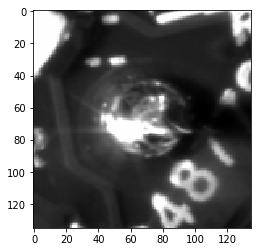

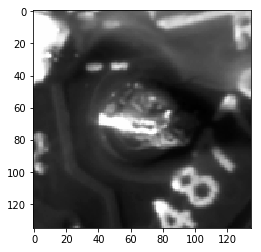

In [20]:
plt.imshow(X_test_crop[88], cmap='gray') # Label: Not_Full, Pred: Good
plt.axis('off')
plt.show()
plt.imshow(X_test_crop[85], cmap='gray') # Label: Not_Full, Pred: Other
plt.show()
plt.imshow(X_test_crop[84], cmap='gray') # Label: Not_Full, Pred: Other
plt.show()
plt.imshow(X_test_crop[9], cmap='gray') # Label: Not_Full, Pred: Other
plt.show()
plt.imshow(X_test_crop[23], cmap='gray') # Label: Good, Pred: Not_Melt
plt.show()
plt.imshow(X_test_crop[65], cmap='gray') # Label: Good, Pred: Not_Full
plt.show()
plt.imshow(X_test_crop[78], cmap='gray') # Label: Good, Pred: Not_Full
plt.show()
plt.imshow(X_test_crop[73], cmap='gray') # Label: Good, Pred: Not_Full
plt.show()
plt.imshow(X_test_crop[27], cmap='gray') # Label: Good, Pred: Not_Full
plt.show()
plt.imshow(X_test_crop[25], cmap='gray') # Label: Good, Pred: Not_Full
plt.show()

# Pad_S容易被當作是Not_Full，因為Pad_C跟Pad_R比較大顆

### BurnGreen and SN_Link Vis

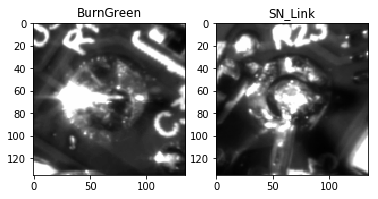

In [19]:
f, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(X_test_crop[35], cmap="gray")
ax[0].set_title('BurnGreen')
ax[1].imshow(X_test_crop[95], cmap='gray')
ax[1].set_title('SN_Link')
plt.show()

In [24]:
y_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 1., 1., 3., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 3.,
       3., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2.,
       2., 1., 1., 1., 3., 3., 3., 3., 3., 3., 5.])